In [713]:
!pip -q install torch torchvision matplotlib

In [714]:
import os
import numpy as np

import torch
from torch import nn
from torch.nn import functional as F
from torch.utils import data
from torch.nn.modules.utils import _pair

from torchvision import transforms

from PIL import Image

from matplotlib import pyplot as plt

device = "cuda" if torch.cuda.is_available() else "cpu"

print(f"Using device : {device}")

Using device : cuda


In [715]:
class SelfAttention(nn.Module):

  def __init__(self, num_heads, KV_size, query_size):

    super(SelfAttention, self).__init__()

    self.num_heads = num_heads
    self.KV_size = KV_size
    self.query_size = query_size

    self.values = nn.Linear(self.KV_size, self.KV_size, bias = False)
    self.keys = nn.Linear(self.KV_size, self.KV_size, bias = False)
    self.queries = nn.Linear(self.query_size, self.query_size, bias = False)
    self.fc_out = nn.Linear(self.query_size, self.query_size)

    self.attention_dropout = nn.Dropout(0.1)
    self.dropout = nn.Dropout(0.1)


  def forward(self, key, query, value):
    
    N = query.shape[0]
    value_len, key_len, query_len = value.shape[1], key.shape[1], query.shape[1]

    # Repeat the key for each head
    keys = key[:, :, None, :].repeat(1, 1, self.num_heads, 1)
    queries = query[:, :, None, :].repeat(1, 1, self.num_heads, 1)
    values = value[:, :, None, :].repeat(1, 1, self.num_heads, 1)

    keys = self.keys(keys) # torch.Size([1, 64, 4, 480])
    queries = self.queries(queries) # torch.Size([1, 64, 4, 32])
    values = self.values(values) # torch.Size([1, 64, 4, 480])

    # MatMul Q and K # torch.Size([1, 4, 32, 480])
    energy = torch.einsum("ndhq,ndhk->nhqk", [queries, keys])

    attention = torch.softmax(energy / (self.KV_size ** 0.5), dim = 3)

    attention = self.attention_dropout(attention)

    out = torch.einsum("nhql,ndhl->ndqh", [attention, values]).mean(dim = 3)

    out = self.fc_out(out)

    return self.dropout(out)


In [716]:
class TransformerBlock(nn.Module):

  def __init__(
    self,
    num_heads,
    query_size,
    KV_size = 480,
    hidden_dim = 480 * 4,
  ):
    super(TransformerBlock, self).__init__()

    self.layer_norm = nn.LayerNorm(query_size, eps = 1e-6)

    self.attention = SelfAttention(num_heads, KV_size, query_size)

  
    self.fc1 = nn.Linear(query_size, hidden_dim)
    self.activation = nn.GELU()
    self.dropout = nn.Dropout(0.0)
    self.fc2 = nn.Linear(hidden_dim, query_size)  

    nn.init.xavier_uniform_(self.fc1.weight)
    nn.init.xavier_uniform_(self.fc2.weight)
    nn.init.normal_(self.fc1.bias, std = 1e-6)
    nn.init.normal_(self.fc2.bias, std = 1e-6)


  def feed_forward(self, x):
    x = self.fc1(x)
    x = self.activation(x)
    x = self.dropout(x)
    x = self.fc2(x)
    x = self.dropout(x)
    return x


  def forward(self, key, query, value):

    normalized_query = self.layer_norm(query)

    attention_out = self.attention(key, normalized_query, value)

    out = attention_out + query

    norm_out2 = self.layer_norm(out)

    feed_forward_out = self.feed_forward(norm_out2)

    return out + feed_forward_out

In [717]:
class CSMHA(nn.Module):

  def __init__(
    self,
    num_cmha_layers,
    KV_size,
    channel_num,
    num_heads
  ):
    super(CSMHA, self).__init__()

    self.attention_blocks = [TransformerBlock(
      num_heads, channel_num[idx], KV_size) for idx in range(num_cmha_layers) ]
    self.KV_norm = nn.LayerNorm(KV_size, eps = 1e-6)


  def forward(self, inputs):
    value = self.KV_norm(torch.cat(inputs, dim = 2))

    key = value.detach().clone()

    channel_wise_attention = [
      channel_layer(key, inputs[ix], value) for ix, channel_layer in enumerate(self.attention_blocks)]

    return channel_wise_attention


In [718]:
class ChannelEmbedding(nn.Module):
  """
    Construct the embeddings from patch and position embeddings.
  """

  def __init__(
    self,
    patch_size,
    image_size,
    in_channels
  ):
    super(ChannelEmbedding, self).__init__()

    image_size = _pair(image_size)
    patch_size = _pair(patch_size)

    n_patches = (image_size[0] // patch_size[0]) * (
      image_size[1] // patch_size[1])

    self.patch_embeddings = nn.Conv2d(
      in_channels, in_channels, patch_size, patch_size)

    self.position_embedding = nn.Parameter(
      torch.zeros(1, n_patches, in_channels))

    self.dropout = nn.Dropout(0.1)


  def forward(self, x):
    patch_embeddings = self.patch_embeddings(x)

    flatten_patches = patch_embeddings.flatten(2)

    flatten_patches = flatten_patches.transpose(-1, -2)

    return self.dropout(flatten_patches + self.position_embedding)


In [719]:
class Reconstruct(nn.Module):
  def __init__(self, in_channels, out_channels, kernel_size, scale_factor):
    super(Reconstruct, self).__init__()

    self.upsample = nn.Upsample(scale_factor = scale_factor)

    self.conv = nn.Conv2d(in_channels, out_channels, kernel_size = kernel_size)
    self.norm = nn.BatchNorm2d(out_channels)
    self.activation = nn.ReLU(inplace = True)
    self.scale_factor = scale_factor


  def forward(self, x):
    # reshape from (B, n_patch, hidden) to (B, h, w, hidden)
    B, n_patch, hidden = x.size()
    h, w = int(np.sqrt(n_patch)), int(np.sqrt(n_patch))

    x = x.permute(0, 2, 1)
    x = x.contiguous().view(B, hidden, h, w)

    x = self.upsample(x)

    out = self.conv(x)
    out = self.norm(out)
    out = self.activation(out)
    
    return out

In [720]:
class CMSFFT(nn.Module):

  def __init__(
    self,
    channel_num,
    num_channels,
    KV_size,
    num_cmha_layers,
    num_heads
  ):
    super(CMSFFT, self).__init__()

    self.num_channels = num_channels
    
    self.output_norm = [
      nn.LayerNorm(channel_num[idx], eps = 1e-6) for idx in range(num_channels)]

    self.cmha_layers = [
      CSMHA(
        num_cmha_layers= num_cmha_layers,
        KV_size = KV_size,
        channel_num = channel_num,
        num_heads = num_heads
      )
      for _ in range(num_channels)]


  def forward(self, inputs):
    cmha_output = inputs
    for layer in self.cmha_layers:
      cmha_output = layer(cmha_output)

    cmha_output = [self.output_norm[idx](cmha_output[idx]) for idx in range(self.num_channels)]

    return cmha_output


In [721]:
class ChannelEncoder(nn.Module):

  def __init__(
    self,
    image_size,
    patch_size,
    channel_num,
    num_channels,
    KV_size,
    num_cmha_layers,
    num_heads
  ):
    super(ChannelEncoder, self).__init__()

    self.num_channels = num_channels

    self.embeddings = [
      ChannelEmbedding(patch_size[i], image_size // pow(2, i), channel_num[i])
      for i in range(self.num_channels)]

    self.cmsftt_encoder = CMSFFT(
      channel_num = channel_num, num_channels = num_channels,
      KV_size = KV_size, num_cmha_layers = num_cmha_layers,
      num_heads = num_heads
    )

    self.reconstruct = [
      Reconstruct(
      channel_num[idx], channel_num[idx], kernel_size = 1, scale_factor = patch_size[idx])
      for idx in range(num_channels)
    ]


  def forward(self, inputs):
    embeddings = [ self.embeddings[i](inputs[i]) for i in range(self.num_channels) ]

    cmsftt_output = self.cmsftt_encoder(embeddings)

    reconstructions = [
      self.reconstruct[idx](cmsftt_output[idx]) + inputs[idx] for idx in range(self.num_channels) ]

    return reconstructions


In [722]:
class EqualizedConv2d(nn.Module):
  """
    Progressive Growing of GANs for Improved Quality, Stability, and Variation
    
    Use equalized learning rate

    https://arxiv.org/abs/1710.10196
  """

  def __init__(
    self,
    in_channels,
    out_channels,
    kernel_size,
    stride = 1,
    padding = 0,
    bias = True
  ):
    super(EqualizedConv2d, self).__init__()

    self.weight = nn.Parameter(nn.init.normal_(
      torch.empty(out_channels, in_channels, *_pair(kernel_size))
    ))

    self.use_bias = bias
    self.stride = stride
    self.padding = padding

    if self.use_bias:
      self.bias = nn.Parameter(torch.FloatTensor(out_channels).fill_(0))

    fan_in = np.prod(_pair(kernel_size)) * in_channels
    self.scale = np.sqrt(2) / np.sqrt(fan_in)


  def forward(self, x):
    return F.conv2d(
      input = x,
      weight = self.weight * self.scale,
      bias = self.bias if self.use_bias else None,
      stride = self.stride,
      padding = self.padding
    )

In [723]:
class PixelWiseNorm(nn.Module):

  def __init__(self):
    super(PixelWiseNorm, self).__init__()

  
  def forward(self, x, alpha = 1e-8):

    y = x.pow(2.).mean(dim = 1, keepdim = True).add(alpha).sqrt()

    y = x / y
    return y

In [724]:
class RGBFeatureTransform(nn.Module):
  """
    The RGB image is transformed into a multi channel feature map to be concatenated
    with the feature map with same number of channels in the network

    use_eql: Use equalized learning rate.
  """

  def __init__(self, out_channels, use_eql = True):
    super(RGBFeatureTransform, self).__init__()

    if use_eql: 
      self.conv_1 = EqualizedConv2d(3, out_channels, (1, 1), bias = True)
    else:
      self.conv_1 = nn.Conv2d(3, out_channels, (1, 1), bias = True)

    self.activation = nn.LeakyReLU(0.2)

    self.pixNorm = PixelWiseNorm()

  
  def forward(self, x):
    out = self.pixNorm(self.activation(self.conv_1(x)))

    return out

In [725]:
class FeatureToRGBTransform(nn.Module):

  """
    The multi-channel feature map is converted into RGB image for output to the discriminator.
  """

  def __init__(self, in_channels, use_eql = True):
    super(FeatureToRGBTransform, self).__init__()

    if use_eql:
      self.conv_1 = EqualizedConv2d(in_channels, 3, (1, 1), bias = True)
    else:
      self.conv_1 = nn.Conv2d(in_channels, 3, (1, 1), bias = True)

  
  def forward(self, x):

    return self.conv_1(x)


In [726]:
class MultiHeadSelfAttention(nn.Module):

  def __init__(
    self,
    dim,
    heads = 8,
    qkv_bias = False,
    qk_scale = None,
    dropout_rate = 0.0
  ):
    super(MultiHeadSelfAttention, self).__init__()

    self.num_heads = heads
    head_dim = dim // heads
    self.scale = qk_scale or head_dim ** -0.5

    self.qkv = nn.Linear(dim, dim * 3, bias = qkv_bias)
    self.attn_drop = nn.Dropout(dropout_rate)
    self.proj = nn.Linear(dim, dim)
    self.proj_drop = nn.Dropout(dropout_rate)


  def forward(self, x):
    B, N, C = x.shape

    qkv = (
      self.qkv(x)
      .reshape(B, N, 3, self.num_heads, C // self.num_heads)
      .permute(2, 0, 3, 1, 4)
    )

    q, k, v = (
      qkv[0],
      qkv[1],
      qkv[2]
    )

    attn = (q @ k.transpose(-2, -1)) * self.scale

    attn = attn.softmax(dim = 1)

    attn = self.attn_drop(attn)

    x = (attn @ v).transpose(1, 2).reshape(B, N, C)
    x = self.proj(x)
    x = self.proj_drop(x)

    return x

In [727]:
class MultiHeadTransformerBlock(nn.Module):

  def __init__(
    self,
    attn_dropout_rate,
    dim,
    dropout_rate,
    hidden_dim,
    heads
  ):
    super(MultiHeadTransformerBlock, self).__init__()

    self.layer_norm = nn.LayerNorm(dim)
    self.dropout = nn.Dropout(p = dropout_rate)
    self.attention = MultiHeadSelfAttention(
      dim, heads = heads, dropout_rate = attn_dropout_rate)

    self.feed_forward = nn.Sequential(
      nn.Linear(dim, hidden_dim),
      nn.GELU(),
      nn.Dropout(p = dropout_rate),
      nn.Linear(hidden_dim, dim),
      nn.Dropout(p = dropout_rate),
    )


  def forward(self, x):

    x_norm = self.layer_norm(x)

    attn = self.attention(x_norm)

    out = self.dropout(attn)

    out = out + x

    out_norm = self.layer_norm(out)

    out_norm = self.feed_forward(out_norm)

    return out + out_norm

In [728]:
class SGFMT(nn.Module):

  def __init__(
    self,
    img_dim = 512,
    embedding_dim = 512,
    num_layers = 4, #4
    heads = 8, #8
    mlp_dim = 4096, #4096
    dropout_rate = 0.1,
    attn_dropout_rate = 0.1,
    patch_dim = 16
  ):
    super(SGFMT, self).__init__()
    
    self.img_dim = img_dim
    self.patch_dim = patch_dim
    self.num_patches = int((self.img_dim // self.patch_dim) ** 2)
    self.seq_length = self.num_patches
    self.embedding_dim = embedding_dim

    layers = []

    for _ in range(num_layers):
      layers.extend([
        MultiHeadTransformerBlock(attn_dropout_rate, img_dim, dropout_rate, mlp_dim, heads)
      ])
    
    self.transformer = nn.Sequential(*layers)

    self.batch_norm = nn.BatchNorm2d(256)
    self.activation = nn.ReLU(inplace = True)

    self.conv_projection = nn.Conv2d(
      256,
      embedding_dim,
      kernel_size = 3,
      stride = 1,
      padding = 1
    )

    self.position_encoding = nn.Parameter(torch.zeros(1, 256, 512))
    self.dropout = nn.Dropout(dropout_rate)
    self.layer_norm = nn.LayerNorm(embedding_dim)

    self.feature_map = nn.Conv2d(512, 256, kernel_size = 3, padding = 'same')
    
  

  def forward(self, x):
    print('In', x.shape)
    residual = x

    x = self.activation(x)
    x = self.conv_projection(x) # out -> 512, 16, 16 shape -> B, 512, 16, 16
    x = x.permute(0, 2, 3, 1).contiguous() # B, 512, 16, 16 -> B, 16, 16, 512
    x = x.view(x.size(0), -1, self.embedding_dim) # B, 16, 16, 512 -> B, 16 * 16, 512
    
    position_encoding = self.position_encoding + x
    x = self.dropout(position_encoding)

    out = self.transformer(x)
    out = self.layer_norm(out)

    out = out.view(
      out.size(0),
      int(self.img_dim / (self.patch_dim * 2)),
      int(self.img_dim / (self.patch_dim * 2)),
      self.embedding_dim
    )

    out = out.permute(0, 3, 1, 2).contiguous() # 512, 16, 16 -> B, 512, 16, 16
    out = self.feature_map(out)

    return out + residual
    


In [729]:
class ConvBlock(nn.Module):

  def __init__(self, in_channels, out_channels, use_eql = True):
    super(ConvBlock, self).__init__()

    if use_eql:
      self.conv_1 = EqualizedConv2d(in_channels, out_channels, (1, 1), padding = 0, bias = True)
      self.conv_2 = EqualizedConv2d(out_channels, out_channels, (3, 3), padding = 1, bias = True)
      self.conv_3 = EqualizedConv2d(out_channels, out_channels, (3, 3), padding = 1, bias = True)

    else:
      self.conv_1 = nn.Conv2d(in_channels, out_channels, (3, 3), padding = 1, bias = True)
      self.conv_2 = nn.Conv2d(out_channels, out_channels, (3, 3), padding = 1, bias = True)
    
    self.pixNorm = PixelWiseNorm()
    self.activation = nn.LeakyReLU(0.2)


  def forward(self, x):

    y = self.conv_1(self.activation(self.pixNorm(x)))
    residual = y
    y = self.conv_2(self.activation(self.pixNorm(y)))
    y = self.conv_3(self.activation(self.pixNorm(y)))

    return y + residual

In [730]:
class UpConv(nn.Module):

  """"Up Convolution Block"""

  def __init__(self, in_channels, out_channels, use_eql = True):
    super(UpConv, self).__init__()

    if use_eql:
      self.conv_1 = EqualizedConv2d(in_channels, out_channels, (1, 1), padding = 0, bias = True)
      self.conv_2 = EqualizedConv2d(out_channels, out_channels, (3, 3), padding = 1, bias = True)
      self.conv_3 = EqualizedConv2d(out_channels, out_channels, (3, 3), padding = 1, bias = True)
    else:
      self.conv_1 = Conv2d(in_channels, out_channels, (3, 3), padding = 1, bias = True)
      self.conv_2 = Conv2d(out_channels, out_channels, (3, 3), padding = 1, bias = True)


    # pixel_wise feature normalizer
    self.pixelwise_norm = PixelWiseNorm()

    self.activation = nn.LeakyReLU(0.2)

  
  def forward(self, x):
    
    x = F.interpolate(x, scale_factor = 2, mode="bilinear")
    y = self.conv_1(self.activation(self.pixelwise_norm(x)))

    residual = y
    
    y = self.conv_2(self.activation(self.pixelwise_norm(y)))
    y = self.conv_3(self.activation(self.pixelwise_norm(y)))

    return y + residual

In [731]:
class CCA(nn.Module):

  def __init__(self, F_g, F_x):
    super(CCA, self).__init__()

    self.mlp_x = nn.Sequential(
      nn.Flatten(),
      nn.Linear(F_x, F_x)
    )

    self.mlp_g = nn.Sequential(
      nn.Flatten(),
      nn.Linear(F_g, F_x)
    )

    self.activation = nn.ReLU(inplace = True)

  
  def forward(self, g, x):

    # channel wise attention

    avg_pool_x = F.avg_pool2d(x, (x.size(2), x.size(3)), stride = (x.size(2), x.size(3)))
    channel_att_x = self.mlp_x(avg_pool_x)

    avg_pool_g = F.avg_pool2d(g, (g.size(2), g.size(3)), stride = (g.size(2), g.size(3)))

    channel_att_g = self.mlp_g(avg_pool_g)
    channel_att_sum = (channel_att_x + channel_att_g) / 2.0

    scale = torch.sigmoid(channel_att_sum).unsqueeze(2).unsqueeze(3).expand_as(x)

    x_after_channel = x * scale
    
    return self.activation(x_after_channel)

In [732]:
class Generator(nn.Module):
  """
    The Generator is an implementation of modified MSG-Unet-GAN with
    attention based encoder and decoder.

    MSG-Unet-GAN: https://arxiv.org/abs/2105.13067
  """

  def __init__(
    self,
    image_size = 256,
    in_channels = 3,
    out_channels = 3,
    kernel_size = 3,
    max_pool_window_size = 2,
    patch_size = [32, 16, 8, 4],
    channel_num = [32, 64, 128, 256],
    num_channels = 4,
    KV_size = 480,
    num_cmha_layers = 4,
    num_heads = 4,
  ):
    super(Generator, self).__init__()

    self.embedding_dim = 512

    # input image size (256X256)
    self.max_pool = nn.MaxPool2d(max_pool_window_size)

    self.conv1 = nn.Conv2d(in_channels, 16, kernel_size, padding = 'same')
    self.conv1_1 = nn.Conv2d(16, 32, kernel_size, padding = 'same')

    self.rgb_to_feature1 = RGBFeatureTransform(32)
    self.conv2 = nn.Conv2d(32, 32, kernel_size, padding = 'same')
    self.conv2_1 = nn.Conv2d(32, 64, kernel_size, padding = 'same')

    self.rgb_to_feature2 = RGBFeatureTransform(64)
    self.conv3 = nn.Conv2d(64, 64, kernel_size, padding = 'same')
    self.conv3_1 = nn.Conv2d(64, 128, kernel_size, padding = 'same')
    
    self.rgb_to_feature3 = RGBFeatureTransform(128)
    self.conv4 = nn.Conv2d(128, 128, kernel_size, padding = 'same')
    self.conv4_1 = nn.Conv2d(128, 256, kernel_size, padding = 'same')

    self.channel_encoder = ChannelEncoder(
      image_size = image_size,
      patch_size = patch_size,
      channel_num = channel_num,
      num_channels = num_channels,
      KV_size = KV_size,
      num_cmha_layers = num_cmha_layers,
      num_heads = num_heads
    )

    self.sgfmt = SGFMT()

    self.Up5 = UpConv(256, 256)
    self.coatt5 = CCA(F_g = 256, F_x = 256)
    self.Up_conv5 = ConvBlock(512, 256)
    self.Up_conv5_1 = ConvBlock(256, 256)

    self.Up4 = UpConv(256, 128)
    self.coatt4 = CCA(F_g = 128, F_x = 128)
    self.Up_conv4 = ConvBlock(256, 128)
    self.Up_conv4_1 = ConvBlock(128, 128)

    self.Up3 = UpConv(128, 64)
    self.coatt3 = CCA(F_g = 64, F_x = 64)
    self.Up_conv3 = ConvBlock(128, 64)
    self.Up_conv3_1 = ConvBlock(64, 64)

    self.Up2 = UpConv(64, 32)
    self.coatt2 = CCA(F_g = 32, F_x = 32)
    self.Up_conv2 = ConvBlock(64, 32)
    self.Up_conv2_1 = ConvBlock(32, 32)

    self.conv = nn.Conv2d(32, out_channels, kernel_size = 1, stride = 1, padding = 0)

    self.feature_to_rgb1 = FeatureToRGBTransform(32)
    self.feature_to_rgb2 = FeatureToRGBTransform(64)
    self.feature_to_rgb3 = FeatureToRGBTransform(128)
    self.feature_to_rgb4 = FeatureToRGBTransform(256)


  def forward(self, x):
    conv1_output = self.conv1_1(self.conv1(x))
    # conv1: 256 * 256 * 3 -> 256 * 256 * 16
    # conv1_1: 256 * 256 * 16 -> 256 * 256 * 32
    
    conv2_input = self.max_pool(conv1_output) + self.rgb_to_feature1(self.max_pool(x))
    conv2_output = self.conv2_1(self.conv2(conv2_input))
    # max_pool : 128 * 128 * 32
    # conv2 : 128 * 128 * 32 -> 128 * 128 * 32 1x1 convolution
    # conv2_1 : 128 * 128 * 32 -> 128 * 128 * 64

    conv3_input = self.max_pool(conv2_output) + self.rgb_to_feature2(self.max_pool(self.max_pool(x)))
    conv3_output = self.conv3_1(self.conv3(conv3_input))
    # max_pool : 64 * 64 * 64
    # conv3 : 64 * 64 * 64 -> 64 * 64 * 64 1x1 convolution
    # conv3_1 : 64 * 64 * 64 -> 64 * 64 * 128
    
    conv4_input = self.max_pool(conv3_output) + self.rgb_to_feature3(
      self.max_pool(self.max_pool(self.max_pool(x))))
    conv4_output = self.conv4_1(self.conv4(conv4_input))
    # max_pool : 64 * 64 * 128 -> 32 * 32 * 128
    # conv4 : 32 * 32 * 128 -> 32 * 32 * 128 1x1 convolution
    # conv4_1 : 32 * 32 * 128 -> 32 * 32 * 256

    # CMSFFT (channel wise attention)
    channel_encoder_output = self.channel_encoder([
      conv1_output, conv2_output, conv3_output, conv4_output])

    # SGFMT (spatial attention)
    out = self.sgfmt(self.max_pool(conv4_output))

    # Up Scaling

    output = []

    d5 = self.Up5(out)
    e4_attn = self.coatt5(g = d5, x = channel_encoder_output[3])
    d5 = torch.cat((e4_attn, d5), dim = 1)
    d5 = self.Up_conv5(d5)
    d5 = self.Up_conv5_1(d5)

    # 256
    out3 = self.feature_to_rgb4(d5)
    
    output.append(out3)

    d4 = self.Up4(d5)
    e3_att = self.coatt4(g = d4, x = channel_encoder_output[2])
    d4 = torch.cat((e3_att, d4), dim = 1)
    d4 = self.Up_conv4(d4)
    d4 = self.Up_conv4_1(d4)

    # 128
    out2 = self.feature_to_rgb3(d4)
    output.append(out2)


    d3 = self.Up3(d4)
    e2_att = self.coatt3(g = d3, x = channel_encoder_output[1])
    d3 = torch.cat((e2_att, d3), dim = 1)
    d3 = self.Up_conv3(d3)
    d3 = self.Up_conv3_1(d3)

    # 64
    out1 = self.feature_to_rgb2(d3)
    output.append(out1)

    d2 = self.Up2(d3)
    e1_att = self.coatt2(g = d2, x = channel_encoder_output[0])
    d2 = torch.cat((e1_att, d2), dim = 1)
    d2 = self.Up_conv2(d2)
    d2 = self.Up_conv2_1(d2)

    # 128
    out0 = self.feature_to_rgb1(d2)
    output.append(out0)

    return output



In [733]:
class Dataset(data.Dataset):

  def __init__(
    self,
    root_folder = './uieb_data/',
    type = "train",
    crop_size = 256,
    train_list_path = './uieb_data/uie_train_list.txt',
    test_list_path = './uieb_data/uie_test_list.txt'
  ):
    self.raw_path = root_folder + 'raw-890/'
    self.gt_path = root_folder + 'reference-890/'
    self.crop_size = crop_size

    self.type = type
    
    if self.type == 'train':
      f = open(train_list_path)
    elif self.type == 'test' or self.type == 'valid':
      f = open(test_list_path)

    self.filenames = f.readlines()


  def __getitem__(self, item):

    raw_item_path = os.path.join(
      self.raw_path, self.filenames[item].rstrip())
    gt_item_path = os.path.join(
      self.gt_path, self.filenames[item].rstrip())

    raw_img = Image.open(raw_item_path)
    gt_img = Image.open(gt_item_path)

    transform = transforms.Compose([
      transforms.Resize((self.crop_size, self.crop_size)),
      transforms.ToTensor()
    ])

    return {
      'raw_img': transform(raw_img),
      'gt_img': transform(gt_img)
    }

  def __len__(self):
    return len(self.filenames)


In [734]:
uieb_dataset = Dataset()

dataloader = data.DataLoader(uieb_dataset, batch_size = 1, shuffle = True)

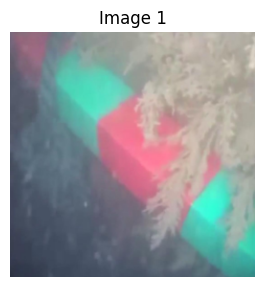

In [735]:
raw_image_batch = next(iter(dataloader))['raw_img']

fig = plt.figure(figsize = (10, 7))

rows, columns = 2, 2

for ix, image in enumerate(raw_image_batch):
  ax = fig.add_subplot(rows, columns, ix + 1)
  ax.set_title('Image ' + str(ix + 1))
  plt.axis('off')
  plt.imshow(image.permute(2, 1, 0))

In [736]:
in_channels = 3
kernel_size = 3

model = Generator()

In torch.Size([1, 256, 16, 16])


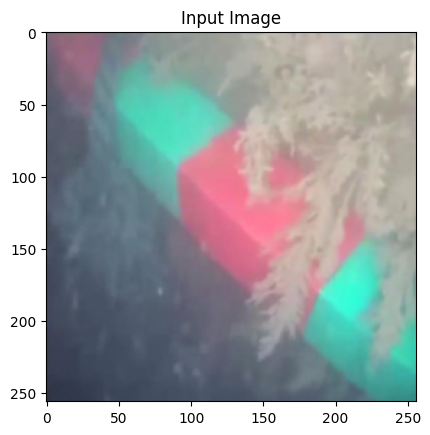

In [737]:
test_image = raw_image_batch[0]

plt.title('Input Image')
plt.imshow(test_image.permute(2, 1, 0))

result = model(raw_image_batch)

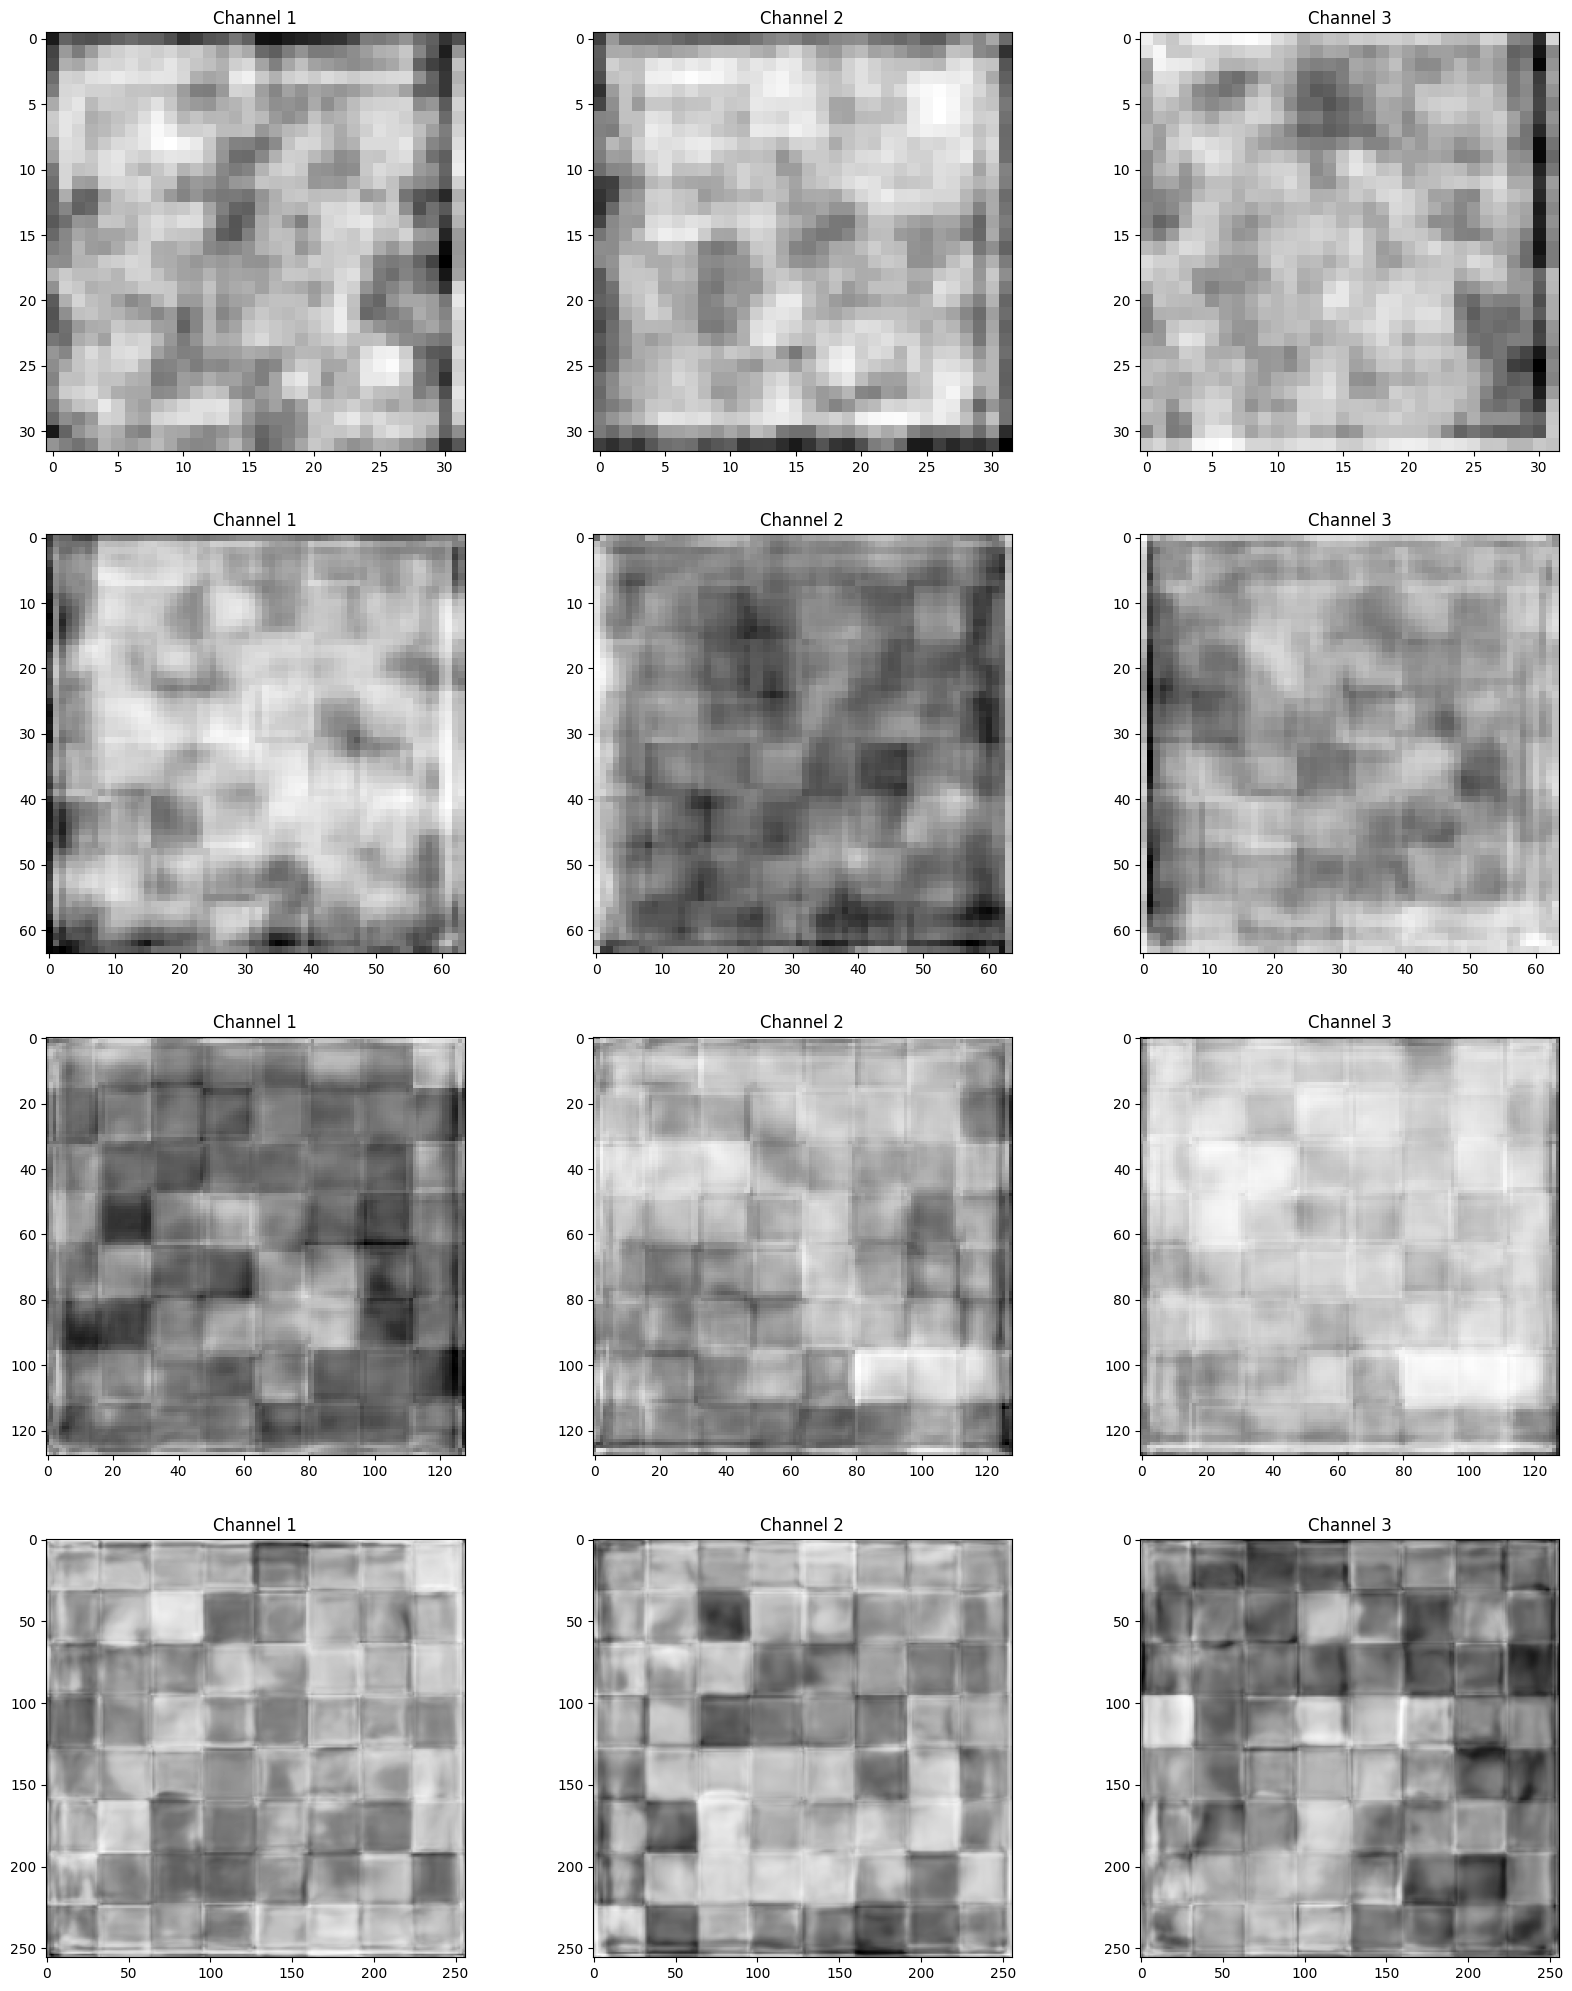

In [738]:
fig = plt.figure(figsize = (20, 25))

rows, columns = 4, 3

for ix, image in enumerate(result):

  for ix1, channel in enumerate(image[0]):
    ax = fig.add_subplot(rows, columns, ix * 3 + ix1 + 1)
    ax.set_title('Channel ' + str(ix1 + 1))

    plt.imshow(channel.detach().numpy(), cmap='Greys')

In [739]:
class DiscriminatorConvBlock(nn.Module):

  """
    General block in the discriminator
  """

  def __init__(self, in_channels, out_channels, use_eql = True):

    super(DiscriminatorConvBlock, self).__init__()

    if use_eql:
      self.conv_1 = EqualizedConv2d(in_channels, out_channels, (3, 3), padding = 1, bias = True)
      self.conv_2 = EqualizedConv2d(in_channels, out_channels, (3, 3), padding = 1, bias = True)

    else:
      self.conv_1 = nn.Conv2d(in_channels, in_channels, (3, 3), padding = 1, bias = True)
      self.conv_2 = nn.Conv2d(in_channels, out_channels, (3, 3), padding = 1, bias = True)

    self.down_sample = nn.AvgPool2d(2)

    self.activation = nn.LeakyReLU(0.2)

  
  def forward(self, x):

    y = self.activation(self.conv_1(x))
    y = self.activation(self.conv_2(y))

    return self.down_sample(y)

In [740]:
class MiniBatchStdDev(nn.Module):
  """
    Minibatch standard deviation layer for the discriminator
  """

  def __init__(self):
    super().__init__()

  def forward(self, x, alpha = 1e-8):

    batch_size, _, height, width = x.shape

    # [B x C x H x W] Subtract mean over batch.
    y = x - x.mean(dim = 0, keepdim = True)

    # [1 x C x H x W] Calc standard deviation over batch
    y = torch.sqrt(y.pow(2.).mean(dim = 0, keepdim = False) + alpha)

    # [1] Take average over feature_maps and pixels
    y = y.mean().view(1, 1, 1, 1)

    # [B x 1 x H x W] Replicate over group and pixels.
    y = y.repeat(batch_size, 1, height, width)

    # [B x C x H x W] Append as new feature_map.
    y = torch.cat([x, y], 1)

    return y

In [741]:
class DiscriminatorFinalBlock(nn.Module):
  """
    Final block for the Discriminator
  """

  def __init__(self, in_channels, use_eql = True):

    super(DiscriminatorFinalBlock, self).__init__()

    # declare the required modules for forward pass
    self.batch_discriminator = MinibatchStdDev()

    if use_eql:
      self.conv_1 = EqualizedConv2d(
        in_channels + 1, in_channels, (3, 3), padding = 1, bias = True)

      self.conv_2 = EqualizedConv2d(
        in_channels, in_channels, (4, 4), stride = 2, padding = 1, bias = True)

      # final layer emulates the fully connected layer
      self.conv_3 = EqualizedConv2d(in_channels, 1, (1, 1), bias = True)

    else:
      self.conv_1 = nn.Conv2d(in_channels + 1, in_channels, (3, 3), padding = 1, bias = True)
      self.conv_2 = nn.Conv2d(in_channels, in_channels, (4, 4), bias = True)

      # final conv layer emulates a fully connected layer
      self.conv_3 = nn.Conv2d(in_channels, 1, (1, 1), bias = True)

    self.activation = nn.LeakyReLU(0.2)

  
  def forward(self, x):

    # minibatch_std_dev layer
    y = self.batch_discriminator(x)

    y = self.activation(self.conv_1(y))
    y = self.activation(self.conv_2(y))

    return self.conv_3(y)

In [742]:
class Discriminator(nn.Module):

  def __init__(self, in_channels = 3, use_eql = True):
    super(Discriminator, self).__init__()

    self.use_eql = use_eql
    self.in_channels = in_channels

    self.rgb_to_feature1 = ModuleList([
      RGBFeatureTransform(32), RGBFeatureTransform(64), RGBFeatureTransform(128)])
    self.rgb_to_feature2 = ModuleList([
      RGBFeatureTransform(32), RGBFeatureTransform(64), RGBFeatureTransform(128)])

    self.layer = EqualizedConv2d(in_channels * 2, 64, (1, 1), bias = True)

    self.pixNorm = PixelWiseNorm()

    self.activation = nn.LeakyReLU(0.2)


    self.layer0 = DiscriminatorConvBlock(64, 64, use_eql = self.use_eql)

    self.layer1 = DiscriminatorConvBlock(128, 128, use_eql = self.use_eql)

    self.layer2 = DiscriminatorConvBlock(256, 256, use_eql = self.use_eql)

    self.layer3 = DiscriminatorConvBlock(512, 512, use_eql = self.use_eql)

    self.layer4 = DiscriminatorFinalBlock(512, use_eql = self.use_eql)


  def forward(self, img_A, inputs):

    x = torch.cat((img_A[3], inputs[3]), 1)
    y = self.pixNorm(self.activation(self.layer(x)))

    y = self.layer0(y)

    x1 = self.rgb_to_feature1[0](img_A[2])
    x2 = self.rgb_to_feature2[0](inputs[2])

    x = torch.cat((x1, x2), 1)
    y = torch.cat((x, y), 1)
    y = self.layer1(y)

    x1 = self.rgb_to_feature1[1](img_A[1])
    x2 = self.rgb_to_feature2[1](inputs[1])
    x = torch.cat((x1, x2), 1)
    y = torch.cat((x, y), 1)
    y = self.layer2(y)

    x1 = self.rgb_to_feature1[2](img_A[0])
    x2 = self.rgb_to_feature2[2](inputs[0])
    x = torch.cat((x1, x2), 1)
    y = torch.cat((x, y), 1)
    y = self.layer3(y)

    y = self.layer4(y)

    return y

In [743]:
# Loss function
# L_GAN + alpha * L_LAB + beta * L_LCH + gamma * L_RGB + myu * L_perceptual
# alpha, beta, gamma and myu are hyperparameters which are set as 0.001, 1, 0.1, 100 respectively.